In [ ]:
!pip install gensim==4.1.2

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Will take 3-5 seconds to run
def load_fixed_train_df(original_train_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train.csv",
                        update_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv",
                        was_fixed_col=False):
    def _fix_tm_ph(_row, update_map):
        update_vals = update_map.get(_row["seq_id"], None)
        if update_vals is not None:
            _row["tm"] = update_vals["tm"]
            _row["pH"] = update_vals["pH"]
        return _row

    # Load dataframes
    _df = pd.read_csv(original_train_file_path)
    _updates_df = pd.read_csv(update_file_path)

    # Identify which sequence ids need to have the tm and pH values changed and create a dictionary mapping 
    seqid_2_phtm_update_map = _updates_df[~pd.isna(_updates_df["pH"])].groupby("seq_id")[["pH", "tm"]].first().to_dict("index")

    # Identify the sequence ids that will be dropped due to data quality issues
    bad_seqids = _updates_df[pd.isna(_updates_df["pH"])]["seq_id"].to_list()

    # Fix bad sequence ids
    _df = _df[~_df["seq_id"].isin(bad_seqids)].reset_index(drop=True)

    # Fix pH and tm swaparoo
    _df = _df.apply(lambda x: _fix_tm_ph(x, seqid_2_phtm_update_map), axis=1)

    # Add in a bool to track if a row was fixed or not (tm/ph swap will look the same as bad data)
    if was_fixed_col: _df["was_fixed"] = _df["seq_id"].isin(bad_seqids+list(seqid_2_phtm_update_map.keys()))

    return _df


protein_dataset = load_fixed_train_df()
protein_dataset

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


In [ ]:
from sklearn.model_selection import train_test_split
feature_columns = ["protein_sequence", "pH"]
target_columns = "tm"
X_train, X_test, y_train, y_test = train_test_split(protein_dataset[feature_columns], protein_dataset[target_columns], test_size=0.2, random_state=42)

In [21]:
protein_dataset = protein_dataset.dropna()
protein_dataset['seq_len'] = protein_dataset['protein_sequence'].str.len()
protein_dataset

,seq_id,protein_sequence,pH,data_source,tm,seq_len
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,341
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,286
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,497
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,265
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,1451
...,...,...,...,...,...,...
28976,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8,549
28977,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2,469
28978,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6,128
28979,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7,593


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# ax = sns.distplot(protein_dataset['seq_len'].values)
ax = sns.histplot(protein_dataset['seq_len'].values, kde=True, binwidth=100)
ax.set_xlim(0, 3000)
plt.xlabel('sequence length')
plt.ylabel('density')
plt.title(f'sequence length distribution')
plt.grid(True)

NameError: name 'protein_dataset' is not defined

In [39]:
protein_dataset['seq_len'].describe()

count    27727.000000
mean       460.467378
std        419.931685
min          5.000000
25%        220.000000
50%        360.000000
75%        546.000000
max       8798.000000
Name: seq_len, dtype: float64

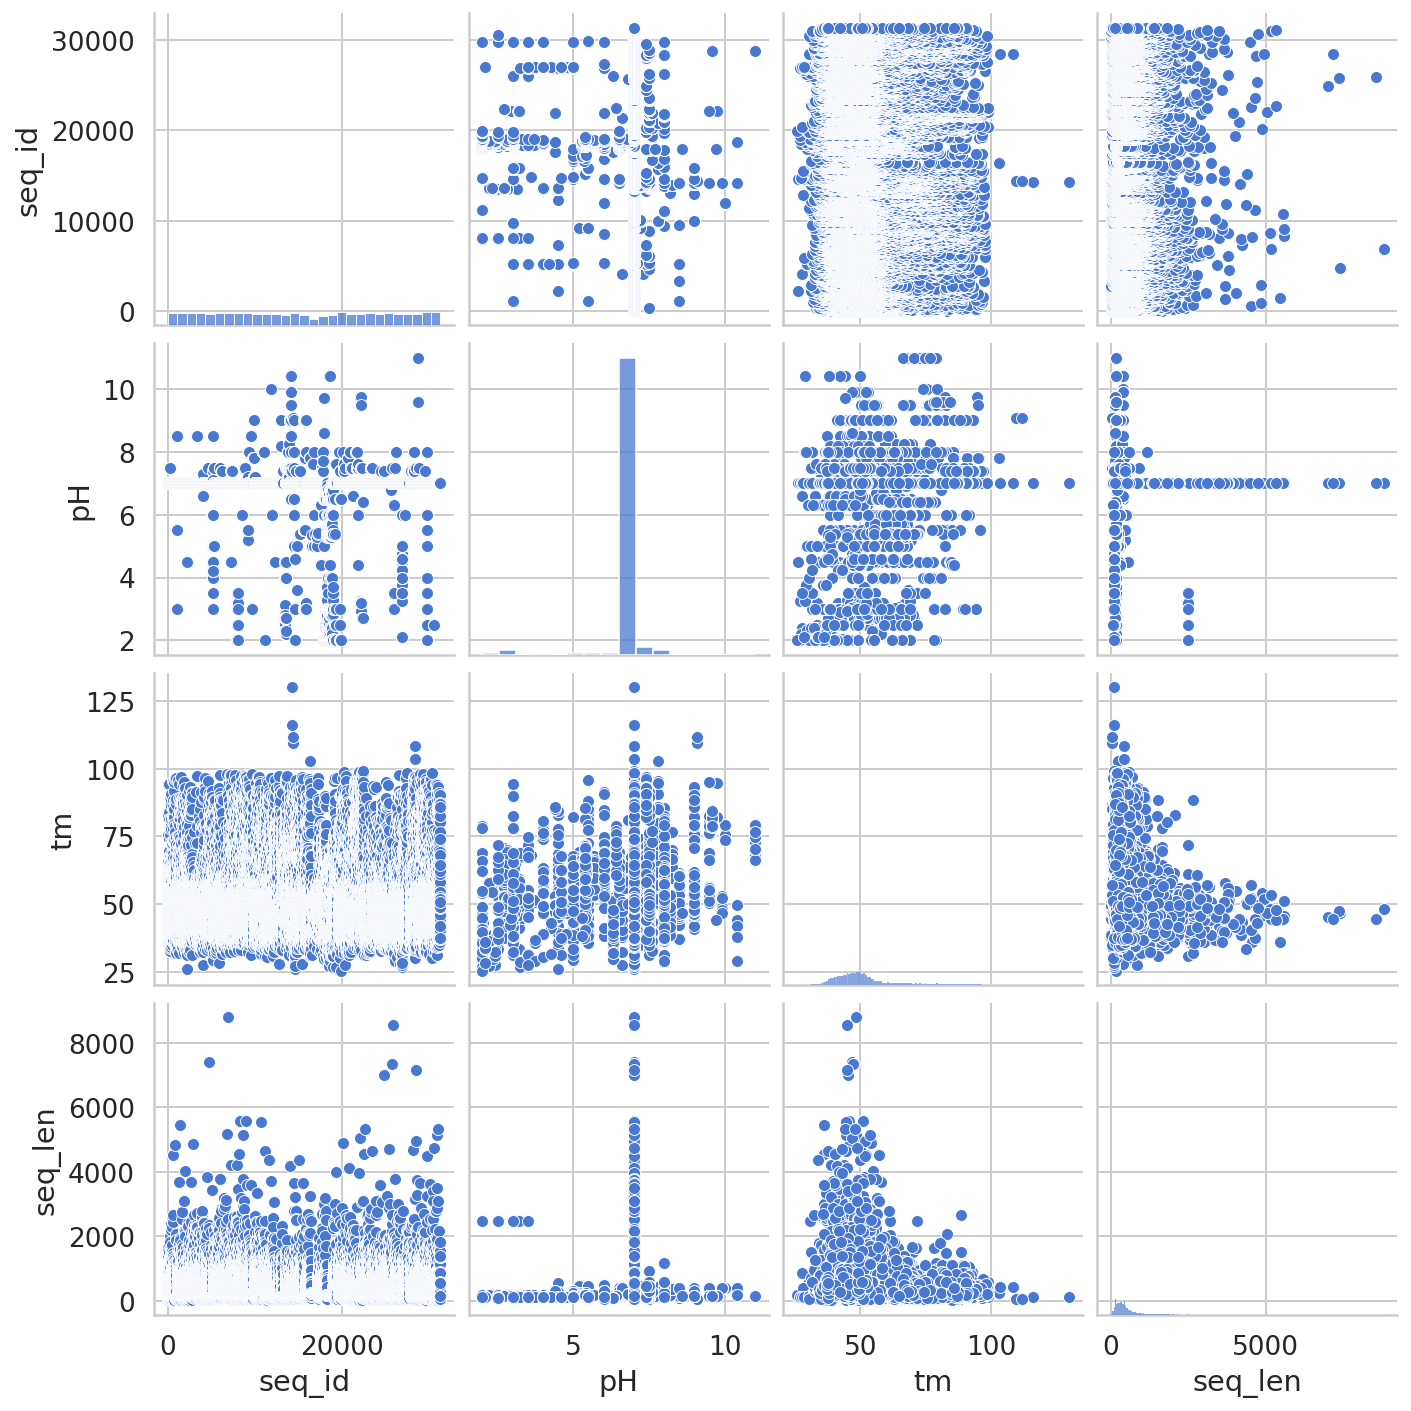

In [56]:
sns.pairplot(data=protein_dataset)

In [1]:
sns.boxplot(x=protein_dataset['tm'])

NameError: name 'sns' is not defined